In [ ]:
!pip install transformers torch umap-learn pillow numpy matplotlib pandas

In [5]:
import torch
import numpy as np
import os
import pickle
import shutil

from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from transformers import CLIPImageProcessor, CLIPModel

# path to the folder with images generated by vikus-viewer-script (1024)
image_path = '../vikus-viewer/data/1024/'
# batch_size for CLIP depends on your GPU memory
batch_size = 10

def create_embeddings(image_folder, batch_size=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
    processor = CLIPImageProcessor.from_pretrained('openai/clip-vit-base-patch32')

    embeddings = {}

    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    
    #image_files = image_files[:20]

    for i in tqdm(range(0, len(image_files), batch_size)):
        batch_files = image_files[i:i + batch_size]
        batch_images = []
        valid_indices = []

        for j, image_file in enumerate(batch_files):
            image_path = os.path.join(image_folder, image_file)

            try:
                image = Image.open(image_path)
                #image = image.resize((224, 224))
            except UnidentifiedImageError:
                print(f"Invalid image file: {image_path}")
                invalid_folder = os.path.join(os.path.dirname(image_folder), 'invalid')
                if not os.path.exists(invalid_folder):
                    os.mkdir(invalid_folder)
                shutil.move(image_path, os.path.join(invalid_folder, image_file))
                continue

            batch_images.append(image)
            valid_indices.append(j)

        inputs = processor(batch_images, return_tensors="pt", padding=True)
        inputs = inputs.to(device)

        with torch.no_grad():
            batch_embeddings = model.get_image_features(**inputs).cpu().numpy()

        for j, image_file in enumerate(batch_files):
            if j not in valid_indices:
                continue

            image_id = os.path.splitext(image_file)[0]
            embeddings[image_id] = batch_embeddings[valid_indices.index(j)]

    return embeddings

embeddings = create_embeddings(image_path, batch_size)


100%|██████████| 64/64 [00:48<00:00,  1.32it/s]


In [ ]:
# save embeddings if you want to use them later
with open('clip-embeddings.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [19]:
# load embeddings if you have already created them
import pickle
with open('clip-embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)

In [33]:
# use umap to reduce dimensionality to 2D
import umap
import numpy as np

reducer = umap.UMAP(random_state=42, min_dist=0.2, spread=3.0, n_neighbors=15)
embedding = np.array(list(embeddings.values()))
embedding = embedding.reshape((embedding.shape[0], -1))
embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
embedding = reducer.fit_transform(embedding)


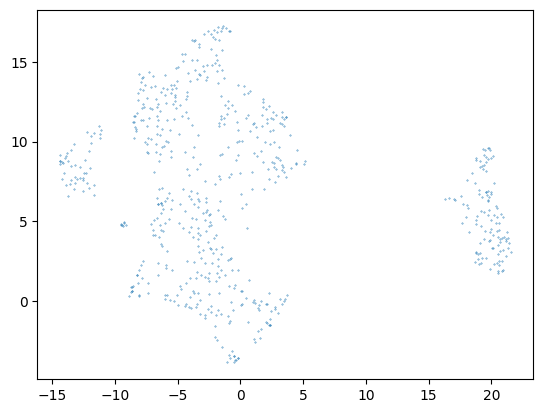

In [35]:
# plot embeddings
import matplotlib.pyplot as plt

plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1)


In [ ]:
# export to csv for visualization with vikus-viewer
import pandas as pd

df = pd.DataFrame(embedding, columns=['x', 'y'])
df['id'] = list(embeddings.keys())
df.to_csv("projection.csv")